<a href="https://colab.research.google.com/github/dirudiez/TFM_DiegoRudiez/blob/main/binario/CEL/Binario_CEL_efficientnet_b3_BalanceoImblearn_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://notebooks.githubusercontent.com/view/ipynb?browser=chrome&color_mode=auto&commit=550a08945499aa9ff119547dc4aefbbeec0e5dbf&device=unknown&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f77616c6b776974686661737461692f77616c6b776974686661737461692e6769746875622e696f2f353530613038393435343939616139666631313935343764633461656662626565633065356462662f6e62732f30325f766973696f6e2e65787465726e616c2e74696d6d2e6970796e62&logged_in=false&nwo=walkwithfastai%2Fwalkwithfastai.github.io&path=nbs%2F02_vision.external.timm.ipynb&platform=android&repository_id=295613905&repository_type=Repository&version=98

En este cuaderno probaremos la arquitectura efficientnet_b3 para ver si obtenemos unos mejores resultados.

## Efficientnet_b3 con Balanceo Sklearn

In [1]:
!pip install fastai -Uq
!pip install timm

#Reiniciamos el entorno de ejecución automáticamente
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

     |████████████████████████████████| 214 kB 27.5 MB/s 
     |████████████████████████████████| 61 kB 7.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 431 kB 21.4 MB/s 


{'restart': True, 'status': 'ok'}

In [1]:
!pip install wwf -q

In [2]:
from fastai.vision.all import *

import timm
from wwf.utils import *
from wwf.vision.timm import *

## Dataset

En este caso estamos usando el dataset que ha sido preprocesados mediante el método de recorte

In [3]:
!wget https://www.dropbox.com/s/o1eaoae59qgdo4i/Training_Set_Pre.zip?dl=0 --no-verbose -O train.zip
!wget https://www.dropbox.com/s/5od5cac9xhxlcwu/Test_Set_Pre.zip?dl=0 --no-verbose -O test.zip
!wget https://www.dropbox.com/s/gjz445xm4oddfus/Evaluation_Set_Pre.zip?dl=0 --no-verbose -O val.zip

2022-07-01 08:30:47 URL:https://uc75164782b403c8186b5203e231.dl.dropboxusercontent.com/cd/0/inline2/BoPgyFlQ4QKkv0pENg-yWh9kpX8Xk4NCHrwtFXCOmyq9dkXmIuQLLXMxKnalE54GurQ4_tyvHEkJgHtL-CZQ-e4VYPRf3YRiYdAER75qsOzOTe7ncI33v-LLB3VH3-lRoD9wXSVcCQy6YSWNYifpPxKblSIx9pYQl6iGuHVIn1T39pU8khNE_cKuE_sJHaBWjHiCj5Sevn8ICj2fmXhaUYOZeDFOtVZzzBK3YD3_Veg1UULXqEe-Sp8ZMsDFr-AehjCNg2Rx6gWoq6PIMGgf29vNPPaXtAHW6va-E1tOh8MyZ2rYDbXJFS5OwFQGyLHByWs6FsTLbx_fhhsgbkwa0GhUePL5pTnc6Or1DLdLQNXflH1X7VmEDC7k9lBby7M7zlXnBOY7KNEiuKZ-cVycBwyIbbv8Zdyx5yRb4QsZuRRm-g/file [138777773/138777773] -> "train.zip" [1]
2022-07-01 08:30:50 URL:https://uccf6681856e496be8c9064c0cbb.dl.dropboxusercontent.com/cd/0/inline2/BoPdcCDFZcP3eucPB44nAy7JVYGZZ2qSFBAG8PgAnKTnuXo-XRpsxoL3hN2DLkuC55cPyrb593cyrV3VYqaX0HBGeZabCqu_WJt9kbePaylahAOjDQ6p85gMOgrygBNCtSv7eJyVodkK0tAb_3iWvzFO2HodIO4AHqB1ievuRBkSgjbceA-00lyw37YI20Hy9S6FF4VTpFDMXYUQKFRthHu1yF70fZGKQaESGgPXi-W6XhHESflyCnRzdHIPxr6Qe04l-d-KffYMgqFpnBDiGPxV2F3sXJjUsaaCWPBynYgYKgQCucypgLxL93gTBCnQN8k

In [4]:
# !rm -rvf Training_Set_Pre
!unzip -qq train.zip #-qq no verbose
!unzip -qq test.zip
!unzip -qq val.zip

In [5]:
#Método para crear estructura de directorios
def crearEstructura(nombreDataset, clases):
  !mkdir "$nombreDataset"
  !mkdir "$nombreDataset"/test
  !mkdir "$nombreDataset"/train
  !mkdir "$nombreDataset"/val
  for x in clases:
    !mkdir "$nombreDataset"/train/"$x"
    !mkdir "$nombreDataset"/test/"$x"
    !mkdir "$nombreDataset"/val/"$x"

In [6]:
crearEstructura('dataset', ['normal', 'enfermedad'])

In [7]:
trainPath = Path('Training_Set_Pre/')
testPath  = Path('Test_Set_Pre/')
valPath  =  Path('Evaluation_Set_Pre/')

In [8]:
df_train = pd.read_csv(str(trainPath) + '/train.csv')
df_test = pd.read_csv(str(testPath) + '/test.csv')
df_val = pd.read_csv(str(valPath) + '/val.csv')

#### Mover imágenes:

In [9]:
import shutil
import uuid

def moverImg(df, pathO, pathD):
  for id, enf in zip(df['ID'], df['Disease_Risk']):
    if(int(enf)==0):
        shutil.copy(pathO + '/' + str(id) + '.png', pathD + '/normal/' + str(uuid.uuid1()) + '.png')
    else:
        shutil.copy(pathO + str(id) + '.png', pathD + '/enfermedad/' + str(uuid.uuid1()) + '.png')

In [10]:
path = Path('dataset')

## Balanceo

In [11]:
y = df_train.Disease_Risk
X = df_train.drop('Disease_Risk', axis=1)

In [12]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

over = RandomOverSampler(sampling_strategy=0.50) #Aumentaremos hasta la mitad de lo que es la clase mayoritaria (759)
under = RandomUnderSampler(sampling_strategy=1) #clase mayoriataria
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

In [13]:
from collections import Counter

# evaluate pipeline
X, y = pipeline.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y)
print(counter)

Counter({0: 759, 1: 759})


In [14]:
X['Disease_Risk'] = y
df_train = X

**Una vez que tenemos el dataframe balanceado comenzamos a copiar las imágenes a las carpetas que corresponda.**

In [15]:
moverImg(df_train, str(trainPath) + '/Training/', str(path)  + '/train')
moverImg(df_test, str(testPath) + '/Test/', str(path)  + '/test')
moverImg(df_val, str(valPath) + '/Validation/', str(path)  + '/val')

## Cargando el dataset

In [16]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(train_name='train', valid_name='val'),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=aug_transforms(size=128,min_scale=0.75))

In [17]:
dls = db.dataloaders(path,bs=128)

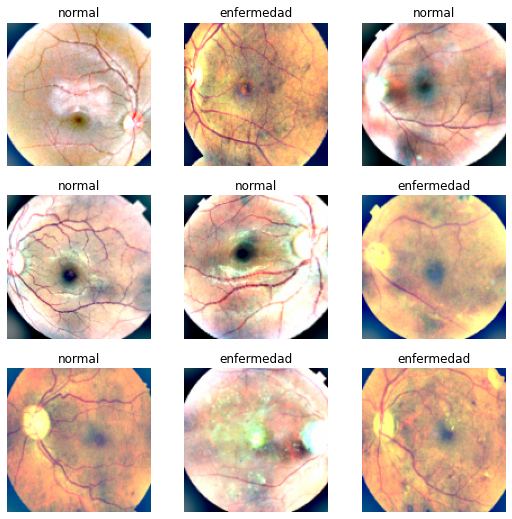

In [18]:
dls.show_batch()

In [19]:
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=20),
    SaveModelCallback()
]

In [62]:
metrics = [ accuracy, Precision(), Recall(), F1Score() ]
learn = timm_learner(dls, 'efficientnet_b3', metrics=metrics, cbs=callbacks).to_fp16()

SuggestedLRs(minimum=0.006918309628963471, steep=0.00015848931798245758, valley=0.0012022644514217973, slide=0.005248074419796467)

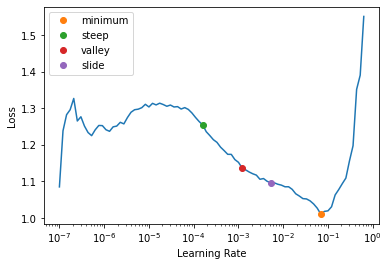

In [63]:
learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

## Entrenamos el modelo

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,1.169075,0.846035,0.637500,0.348765,0.843284,0.493450,00:08


Better model found at epoch 0 with valid_loss value: 0.846034824848175.


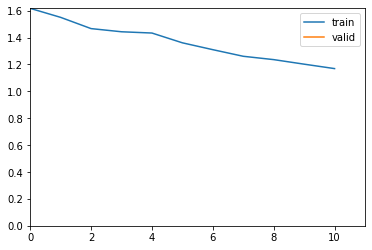

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.830781,0.711776,0.701563,0.396364,0.813433,0.533007,00:08
1,0.839292,0.811623,0.684375,0.381119,0.813433,0.519048,00:09
2,0.830954,0.854170,0.667188,0.371336,0.850746,0.517007,00:08
3,0.833171,0.798225,0.678125,0.379195,0.843284,0.523148,00:09
4,0.799144,0.770194,0.684375,0.380282,0.805970,0.516746,00:09
5,0.778882,0.667282,0.726562,0.418972,0.791045,0.547804,00:08
6,0.769016,0.622727,0.742188,0.436214,0.791045,0.562334,00:09
7,0.767481,0.730840,0.693750,0.393103,0.850746,0.537736,00:09
8,0.745583,0.750598,0.710938,0.407942,0.843284,0.549878,00:08
9,0.738657,0.756326,0.703125,0.402778,0.865672,0.549763,00:09


Better model found at epoch 0 with valid_loss value: 0.7117762565612793.


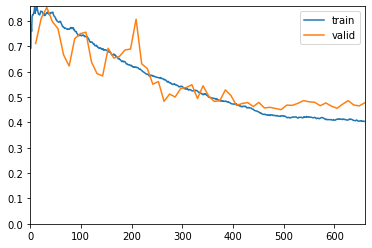

Better model found at epoch 5 with valid_loss value: 0.6672819256782532.
Better model found at epoch 6 with valid_loss value: 0.6227270364761353.
Better model found at epoch 11 with valid_loss value: 0.5926978588104248.
Better model found at epoch 12 with valid_loss value: 0.5837100744247437.
Better model found at epoch 21 with valid_loss value: 0.5508371591567993.
Better model found at epoch 23 with valid_loss value: 0.48349738121032715.
Better model found at epoch 32 with valid_loss value: 0.48308315873146057.
Better model found at epoch 36 with valid_loss value: 0.46712008118629456.
Better model found at epoch 39 with valid_loss value: 0.4629002511501312.
Better model found at epoch 41 with valid_loss value: 0.45727038383483887.
Better model found at epoch 43 with valid_loss value: 0.45512309670448303.
Better model found at epoch 44 with valid_loss value: 0.4507947862148285.
CPU times: user 3min 48s, sys: 22.2 s, total: 4min 11s
Wall time: 9min 33s


In [64]:
%%time
learn.fine_tune(60,base_lr=1e-3)

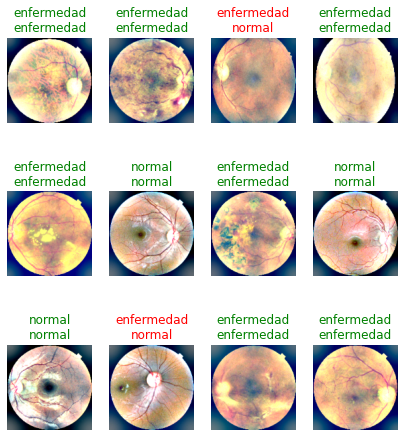

In [65]:
learn.show_results(max_n=12, figsize=(7,8))

## Evaluando el Modelo

In [66]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=aug_transforms(size=128,min_scale=0.75))
dlsTest = dbTest.dataloaders(path,bs=128)

In [67]:
learn.dls = dlsTest

Obtenemos una accuracy de 0.82.

In [68]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.778124988079071.


(#5) [0.4757367968559265,0.778124988079071,0.4829059829059829,0.8432835820895522,0.6141304347826088]

Exportamos el modelo:

In [69]:
learn.to_fp32()
learn.export('Binario_CEL_efficientnet_b3_BalanceoImblearn.pkl')

## Interpretación del modelo

In [70]:
learn.dls=dls

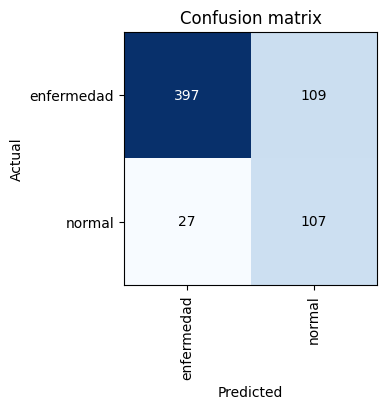

In [71]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(4,4),dpi=100)